In [190]:
import pandas as pd
from astropy.time import Time
from astropy.coordinates import SkyCoord
from datetime import timedelta
from astroquery.jplhorizons import Horizons
import gaiaoffline as go
from datetime import timedelta
import matplotlib.pyplot as plt
import json
import numpy as np

def plot_passes(ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(30, 6), dpi=100)
    for start, end in zip(pass_start_times, pass_end_times):
        ax.axvline(start.jd, c='k', ls='--')
        ax.axvline(end.jd, c='k', ls='--')
        ax.fill_betweenx([0, 1], start.jd, end.jd, color='grey', alpha=0.3)
    ax.set(xlabel='Time [days from now]', yticks=[]);
    ax.axvline(Time.now().jd, c='r')
    return ax


def plot_sequences(ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 6), dpi=100)
    with open(seq_fname, "r") as f:
        seqs = json.load(f)["Commands"]
    sdf = pd.DataFrame([(Time(s['TimeStamp']).jd, s['Command'].split(' ')[1]) for s in seqs])
    sdf['target'] = [s["Command"].split('TARGET_ID')[1].split(",")[0].strip()[1:-1] if ("TARGET_ID" in s["Command"]) else None for s in seqs]
    sdf['target'] = sdf["target"][::-1].ffill()[::-1]
    targ_idx = {targ:idx for idx, targ in enumerate(sdf.target.unique())}
    g = sdf["target"].ne(sdf["target"].shift()).cumsum()
    sdfs = [chunk.reset_index(drop=True) for _, chunk in sdf.groupby(g, sort=False)]
        
    
    for sdf in sdfs:
        if len(sdf) < 4:
            continue
        kdx = np.where(sdf[1].isin(["PAYLOAD_HALT_IMAGING_OR_COMMAND_SEQUENCE"]))[0]
        start = sdf.loc[kdx, 0].values
        duration = sdf.loc[kdx[1:] - 1, 0].values - start[:-1]
        if len(duration) == 0:
            duration = [sdf[0].values[-1] - start[0]]
        else:
            duration = np.hstack([duration, np.median(duration[1:])])
        a = sdf.loc[np.where(sdf[1].isin(["PAYLOAD_HALT_IMAGING_OR_COMMAND_SEQUENCE"]))[0], 0]
        [ax.fill_betweenx([0.25, 0.5], s, e, color=f'C{targ_idx[sdf.target[0]]}', alpha=0.5) for s, e in zip(start, start+duration)]
    return ax

def set_xlim_nextpass(ax):
    ax.set(xlim=(Time.now().jd - 0.01, pass_end_times[1].jd + 0.01))

def set_xlim_sequences(ax):
    with open(seq_fname, "r") as f:
        seqs = json.load(f)["Commands"]
    ax.set(xlim=(Time(seqs[0]['TimeStamp']).jd - 0.01, Time(seqs[-1]['TimeStamp']).jd + 0.01))

def check_times():
    with open(seq_fname, "r") as f:
        seqs = json.load(f)["Commands"]
    assert np.allclose(np.argsort(np.asarray([Time(s["TimeStamp"]).jd for s in seqs])), np.arange(len(seqs))), "Times are not in order!"
    ftimes = np.asarray([Time(s["TimeStamp"]).jd for s in seqs])
    assert len(np.where(np.diff(ftimes) < 0)[0]) == 0, "The sequence file times include negative times delays!!"

def check_target_name():
    with open(seq_fname, "r") as f:
        seqs = json.load(f)["Commands"]
    target_ids = ([s['Command'].split("TARGET_ID")[1].split(',')[0].strip()[1:-1] for s in seqs if "TARGET_ID" in s['Command']])
    for target in target_ids:
        assert len(target) <= 19, f"Target ID {target} is too long!"
        assert "." not in target, f"Target ID {target} format looks wrong."

def check_pathlength():
    with open(seq_fname, "r") as f:
        seqs = json.load(f)["Commands"]
    paths = ([s['Command'].split("PATH")[1].split(',')[0].strip()[1:-1] for s in seqs if "PAYLOAD_READ" in s['Command']])
    for path in paths:
        assert len(path) <= 50, f"Binary path is too long! [{path}]"
    paths = ([s['Command'].split("PL_PATH")[1].split(',')[0].strip()[1:-1] for s in seqs if "PAYLOAD_READ" in s['Command']])
    assert len(paths) != 0, "Set `PLD_PATH` to ''!"
    for path in paths:
        assert path == '', "`PLD_PATH` needs to be set to an empty string."

def check_targets():
    with open(seq_fname, "r") as f:
        seqs = json.load(f)["Commands"]
    x, y, z = np.asarray([(float(s['Command'].split("TARG_X")[1].split(',')[0].strip()), 
                           float(s['Command'].split("TARG_Y")[1].split(',')[0].strip()), 
                           float(s['Command'].split("TARG_Z")[1].split(',')[0].strip())) for s in seqs if "GOTO" in s['Command']]).T
    ra, dec = np.asarray([(s['Command'].split("TARGET_RA")[1].split(',')[0].strip(), 
                           s['Command'].split("TARGET_DEC")[1].split(',')[0].strip(), 
                          ) for s in seqs if "TARGET_RA" in s['Command']]).T

    coord = SkyCoord(ra, dec, unit='deg')
    assert np.allclose(coord.cartesian.xyz.value[0] - x, 0), "TARG_X and RA/Dec do not match!"
    assert np.allclose(coord.cartesian.xyz.value[1] - y, 0), "TARG_Y and RA/Dec do not match!"
    assert np.allclose(coord.cartesian.xyz.value[2] - z, 0), "TARG_Z and RA/Dec do not match!"


def check_all():
    check_times()
    check_target_name()
    check_pathlength()
#     check_targets()

In [269]:
ksat_csv_fname = "../20260129_contacts.csv"
# seq_fname = "20260126T23540_ben_07.seq"

seq_fname = "20260129T20275_vitl_10.seq"

/Users/bhord/anaconda3/envs/pandora/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/bhord/anaconda3/envs/pandora/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


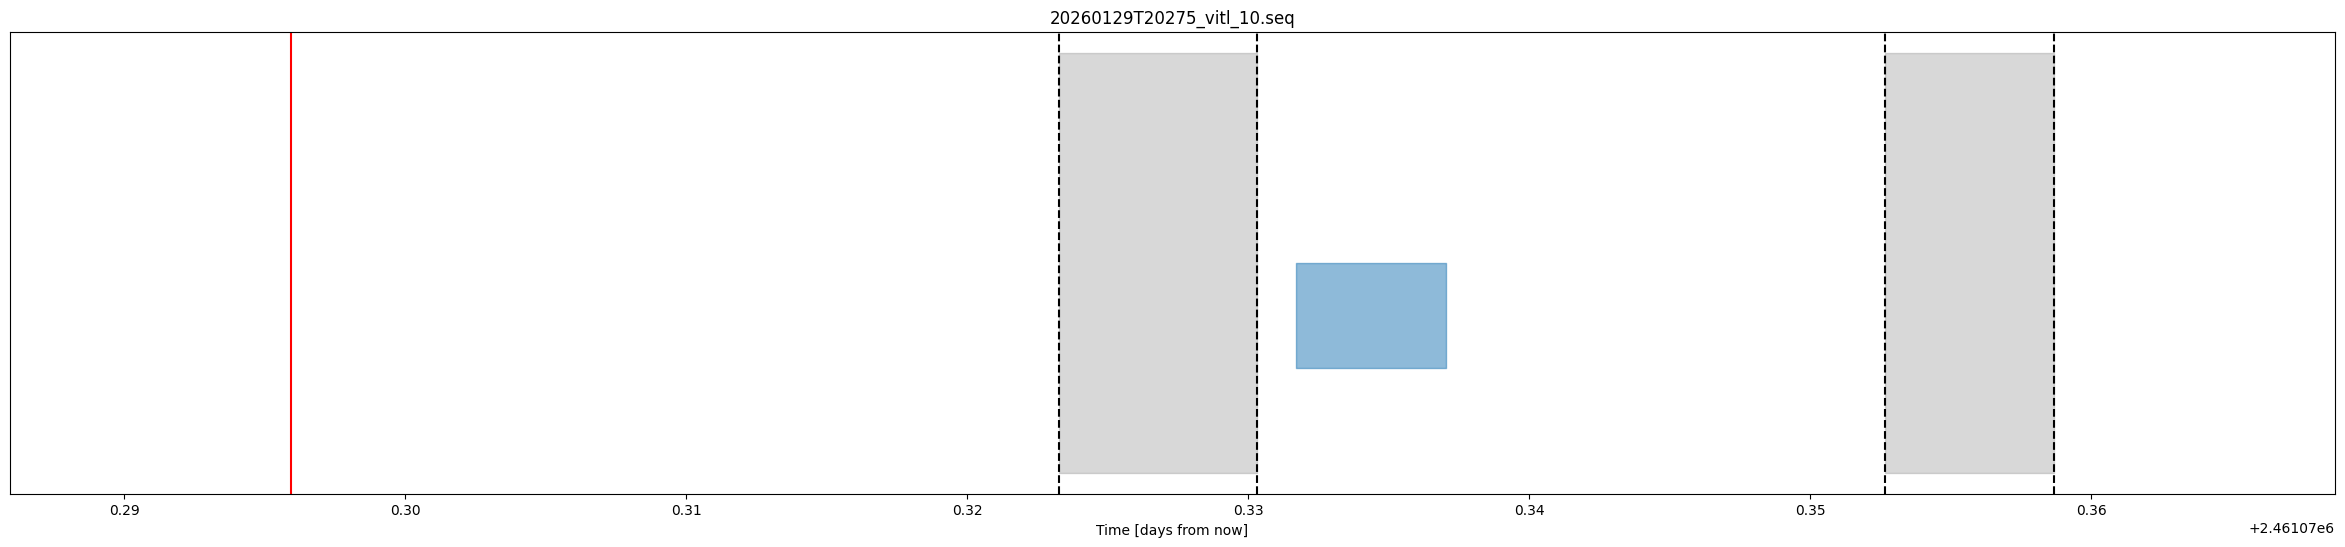

In [270]:
ksat_df = pd.read_csv(ksat_csv_fname)
pass_start_times = [Time(time, scale='utc') for time in ksat_df.start_time if Time(time) > Time.now()]
pass_end_times = [Time(time, scale='utc') for start_time, time in zip(ksat_df.start_time, ksat_df.end_time) if Time(start_time) > Time.now()]

assert len(pass_start_times) > 0, ("**Update your KSAT CSV file**")

pass_start_times, pass_end_times = Time(pass_start_times), Time(pass_end_times)
check_all()
ax = plot_passes()
plot_sequences(ax=ax)
set_xlim_nextpass(ax=ax)
# set_xlim_sequences(ax=ax)
ax.set(title=seq_fname.split('/')[-1]);

In [193]:
json.load(open(seq_fname))

{'Commands': [{'TimeType': 'ABSOLUTE',
   'TimeStamp': '2026-01-28T00:18:10Z',
   'Command': 'PANDORA PAYLOAD_HALT_IMAGING_OR_COMMAND_SEQUENCE'},
  {'TimeType': 'ABSOLUTE',
   'TimeStamp': '2026-01-28T00:18:12Z',
   'Command': 'PANDORA GOTO_TARGET with VEL_ABER 1, PRI_REF_DIR 8, SEC_REF_DIR 2, TARG_X 0.24085569014495237, TARG_Y 0.5967100506965564, TARG_Z -0.7654578054488124, ANGLE 0.000000000000, PRI_CMD_DIR 3, SEC_CMD_DIR 1, ATT_INTERP 0, Q_TARGE_TWRT_REF1 0.000000000000, Q_TARGE_TWRT_REF2 0.000000000000, Q_TARGE_TWRT_REF3 -57.11231813234224, Q_TARGE_TWRT_REF4 0.000000000000, RATE_INTERP 0, CMD_RATE_X 0.000000000000, CMD_RATE_Y 0.000000000000, CMD_RATE_Z 0.000000000000, TIME 0, END_CYCLE 0'},
  {'TimeType': 'ABSOLUTE',
   'TimeStamp': '2026-01-28T00:18:14Z',
   'Command': "PANDORA PAYLOAD_READ with CCSDS_AP_ID HSDR, PL_APID 0, PATH '/mnt/data/sci/20260128T001814_hd29078_01.bin', PL_PATH ''"},
  {'TimeType': 'ABSOLUTE',
   'TimeStamp': '2026-01-28T00:22:18Z',
   'Command': "PANDORA PAY

In [37]:
pass_start_times[0]

<Time object: scale='utc' format='isot' value=2026-01-27T19:20:20.000>